<a href="https://colab.research.google.com/github/aquibjaved/Bits_and_Pieces_DL/blob/main/Basics_of_lora_implementation_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import math

In [150]:
# Define a transform to normalize the data and flatten each image into a 1D array
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data)
    target = torch.tensor(target)
    return data.cuda(), target.cuda()

In [151]:
def plot_flattened_images(flattened_images, labels, img_shape, class_names, num_images=5):
    """
    Plots images that have been flattened.

    Parameters:
        flattened_images (torch.Tensor): The flattened images tensor.
        labels (torch.Tensor): The labels tensor.
        img_shape (tuple): The original shape of the images (e.g., (28, 28) for Fashion MNIST).
        class_names (list): List of class names.
        num_images (int): Number of images to plot.
    """
    # Reshape the flattened images back to their original shape
    reshaped_images = flattened_images.view(-1, *img_shape).numpy()

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

    for i, ax in enumerate(axes):
        img = reshaped_images[i]
        label = class_names[labels[i].item()]
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [152]:
train_dataset = datasets.FashionMNIST('~/.data', download=True, train=True, transform=transform)
test_dataset = datasets.FashionMNIST('~/.data', download=True, train=False, transform=transform)

In [153]:
def split_dataset(dataset, labels):
    indices = [i for i, (data, label) in enumerate(dataset) if label in labels]
    return torch.utils.data.Subset(dataset, indices)

labels_1 = [0, 1, 2, 3, 4]
labels_2 = [5, 6, 7, 8, 9]

train_dataset_04 = split_dataset(train_dataset, labels_1)
train_dataset_59 = split_dataset(train_dataset, labels_2)

batch_size = 64

train_loader_1 = torch.utils.data.DataLoader(train_dataset_04, batch_size=batch_size, shuffle=True)
train_loader_2 = torch.utils.data.DataLoader(train_dataset_59, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

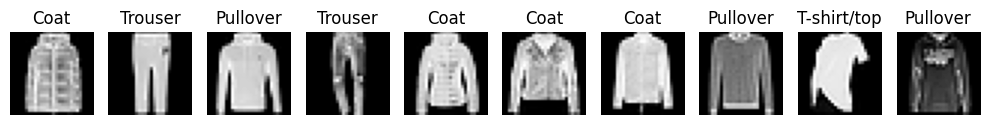

In [156]:
# Get one batch of images and labels
dataiter = iter(train_loader_1)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [157]:
class FashionNet(nn.Module):
  def __init__(self, input_dims, num_class, input_hidden_size, hidden_layer_size):

    super().__init__()
    self.input_dims = input_dims
    self.num_class = num_class
    self.input_hidden_size = input_hidden_size
    self.hidden_layer_size=hidden_layer_size


    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=self.input_hidden_size)
    self.hidden_layer = nn.Linear(in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.output_layer = nn.Linear(in_features=self.hidden_layer_size, out_features=self.num_class)

  def forward(self, x):
    out = F.relu(self.input_layer(x))
    out = F.relu(self.hidden_layer(out))
    out = self.output_layer(out)
    return out

In [158]:
# Check for GPU availability
cuda_available = torch.cuda.is_available()

In [228]:
import torch
device='cpu'


def train_model(epochs:int, train_loader, model, optimizer, criterion):
  model.train()
  train_loss_per_epoch = []

  for epoch in range(epochs):

    running_loss_train = 0.0

    for data_batch, target_batch in train_loader:

        data_batch = data_batch.to(device)
        target_batch = target_batch.to(device)

        optimizer.zero_grad()
        output = model(data_batch)
        loss_train = criterion(output, target_batch)
        # loss_train.requires_grad=True
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.item()

    epcoh_loss_train = running_loss_train / len(train_loader)

    train_loss_per_epoch.append(epcoh_loss_train)


    if epoch %2 == 0:
      print(f'Epoch {epoch} Train loss {epcoh_loss_train}')
  return train_loss_per_epoch


import torch
from sklearn.metrics import confusion_matrix
import numpy as np

def test(test_loader, net):
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in test_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for the Label {i}: {wrong_counts[i]}')



In [209]:
BigNet = FashionNet(input_dims=784, num_class=len(class_names), input_hidden_size=1000, hidden_layer_size=2000)
optimizer = optim.SGD(BigNet.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

device = 'cpu'
# Assume `model` is your model
if cuda_available:
    BigNet = BigNet.to(device)
    optimizer = optim.SGD(BigNet.parameters(), lr=0.011, momentum=0.9)
    criterion = nn.CrossEntropyLoss().to(device)

is_on_gpu = next(BigNet.parameters()).is_cuda
print(f'Model is on GPU: {is_on_gpu}')

trainable_params = sum(p.numel() for p in BigNet.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

Model is on GPU: False
Number of trainable (tunable) parameters: 2807010


In [210]:
trainLoss = train_model(epochs=2,
                        train_loader=train_loader_1,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

Epoch 0 Train loss 1.5847177131852108


In [211]:
torch.save(BigNet.state_dict(), 'model.pt')

In [212]:
test(
      test_loader=test_loader,
      net=BigNet,
)

original_weights = {}
for name, param in BigNet.named_parameters():
    original_weights[name] = param.clone().detach()

Accuracy: 0.388
wrong counts for the Label 0: 214
wrong counts for the Label 1: 108
wrong counts for the Label 2: 253
wrong counts for the Label 3: 153
wrong counts for the Label 4: 397
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [76]:
# Load the model and test it
model = FashionNet(input_dims=784, num_class=len(class_names), input_hidden_size=1000, hidden_layer_size=2000)
model.load_state_dict(torch.load('model.pt'))
model.to('cpu')
# Call the function
test(
      test_loader=test_loader,
      net=model,
)

Accuracy: 0.392
wrong counts for the Label 0: 190
wrong counts for the Label 1: 102
wrong counts for the Label 2: 307
wrong counts for the Label 3: 174
wrong counts for the Label 4: 307
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [164]:
total_parameters_original = 0
for index, layer in enumerate([BigNet.input_layer, BigNet.hidden_layer, BigNet.output_layer]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


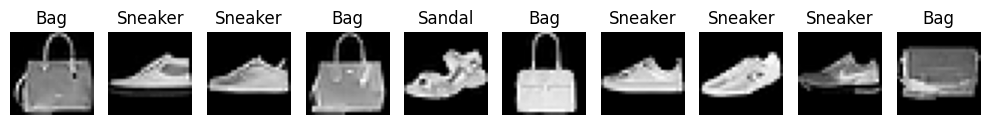

In [213]:
# Get one batch of images and labels
dataiter = iter(train_loader_2)
images, labels = next(dataiter)

# Define the class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot_flattened_images(flattened_images=images, labels=labels, img_shape=(28,28), num_images=10, class_names=class_names)

In [214]:
class LoraLinear(nn.Module):
  def __init__(self, r, in_features, out_features):
    super().__init__()
    self.r = r
    self.in_features = in_features
    self.out_features = out_features
    self.lora_A = nn.Parameter(torch.empty(self.in_features, self.r), requires_grad=True)
    self.lora_B = nn.Parameter(torch.empty(self.r, self.out_features), requires_grad=True)
    nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
    nn.init.zeros_(self.lora_B)

  def forward(self, x):
    return x+(self.lora_A @self.lora_B)

In [225]:
from functools import partial

class LoRAParametrization(nn.Module):
    def __init__(self, fan_in, fan_out, rank=4, lora_dropout_p=0.0, lora_alpha=1):
        super().__init__()
        # if weight is stored as (fan_out, fan_in), the memory layout of A & B follows (W + BA)x
        # otherwise, it's x(W + AB). This allows us to tie the weights between linear layers and embeddings

        self.lora_A = nn.Parameter(torch.zeros(rank, fan_in))
        self.lora_B = nn.Parameter(torch.zeros(fan_out, rank))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank

        self.forward_fn = self.lora_forward


    def lora_forward(self, X):
        return X + torch.matmul(self.lora_B, self.lora_A).view(X.shape) * self.scaling

    def forward(self, X):
        return self.forward_fn(X)



    @classmethod
    def from_linear(cls, layer, rank=4, lora_dropout_p=0.0, lora_alpha=1):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in, fan_out, rank=rank, lora_dropout_p=lora_dropout_p, lora_alpha=lora_alpha
        )

In [226]:
default_lora_config = {  # specify which layers to add lora to, by default only add to linear layers
    nn.Linear: {
        "weight": partial(LoRAParametrization.from_linear, rank=4),
    },
}

def apply_lora(layer, register=True, merge=False, lora_config=default_lora_config):
      """add lora parametrization to a layer, designed to be used with model.apply"""
      if register:
          if type(layer) in lora_config:
              for attr_name, parametrization in lora_config[type(layer)].items():
                  nn.utils.parametrize.register_parametrization(layer, attr_name, parametrization(layer))
      else:  # this will remove all parametrizations, use with caution
          if hasattr(layer, "parametrizations"):
              for attr_name in layer.parametrizations.keys():
                  nn.utils.parametrize.remove_parametrizations(layer, attr_name, leave_parametrized=merge)

def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )

def add_lora(model, lora_config=default_lora_config):
    """add lora parametrization to all layers in a model. Calling it twice will add lora twice"""
    model.apply(partial(apply_lora, lora_config=lora_config))


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p

def get_lora_params(model, print_shapes=False):
    return get_params_by_name(model, print_shapes=print_shapes, name_filter=name_is_lora)



In [229]:
lora_model = BigNet.to('cpu')
# Step 1: Add LoRA to the model
add_lora(lora_model)

# Step 2: Collect the parameters, pass them to the optimizer

parameters = [
    {"params": list(get_lora_params(lora_model))},
]

optimizer = optim.SGD(BigNet.parameters(), lr=0.0001, momentum=0.9)

trainLoss = train_model(epochs=2,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=BigNet,
                        )

# lora_model.load_state_dict(torch.load('model.pt'), strict=False)

test(
      test_loader=test_loader,
      net=lora_model,
)


Epoch 0 Train loss 1.840040989140712
Accuracy: 0.423
wrong counts for the Label 0: 1000
wrong counts for the Label 1: 1000
wrong counts for the Label 2: 1000
wrong counts for the Label 3: 1000
wrong counts for the Label 4: 1000
wrong counts for the Label 5: 243
wrong counts for the Label 6: 86
wrong counts for the Label 7: 153
wrong counts for the Label 8: 183
wrong counts for the Label 9: 104


In [233]:
for param in lora_model.named_parameters():
  print(param)

('input_layer.bias', Parameter containing:
tensor([-1.6734e-02,  1.7016e-02,  3.0122e-02, -1.3094e-02,  2.1236e-02,
        -7.2922e-03, -6.7987e-03, -2.1493e-02, -9.3570e-03,  8.8435e-03,
        -2.7106e-02,  6.4334e-03,  3.5767e-02,  1.9182e-02,  2.4822e-02,
        -1.1378e-02, -1.1398e-02, -1.3033e-02,  2.9379e-02, -2.9637e-02,
         2.4909e-02, -2.7210e-02, -1.9742e-03,  3.0884e-02,  3.6142e-02,
         3.5806e-02,  1.0486e-02, -2.5972e-02,  1.0690e-02,  3.3566e-02,
         1.3839e-03,  1.9440e-02, -1.4129e-02,  6.6525e-03,  2.9883e-02,
         1.4318e-02, -8.3286e-03, -5.9578e-03,  2.2485e-03, -1.2473e-02,
        -1.4219e-02, -1.6354e-02, -8.1316e-03, -4.8947e-03,  3.4987e-04,
        -1.6555e-02,  2.2905e-02,  3.1108e-02,  5.3865e-03, -1.0771e-02,
         1.8586e-02, -3.0432e-02, -2.7327e-02,  1.3678e-02, -1.6527e-02,
        -3.3715e-03,  2.6847e-02, -3.0869e-02, -2.0953e-02, -1.4293e-02,
        -1.6530e-03,  1.4420e-02,  2.9842e-02, -6.1550e-03,  1.8126e-02,
        

In [215]:
class LoraModel(FashionNet):
  def __init__(self, r, alpha, input_dims=784, num_class=len(class_names), input_hidden_size=1000, hidden_layer_size=2000):

    super().__init__(input_dims=input_dims, num_class=num_class, input_hidden_size=input_hidden_size ,hidden_layer_size=hidden_layer_size)

    self.r = r
    self.alpha = alpha

    self.input_layer_lora = LoraLinear(r=self.r, in_features=self.input_dims, out_features=self.input_hidden_size)
    self.hidden_layer_lora = LoraLinear(r=self.r, in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.out_layer_lora = LoraLinear(r=self.r, in_features=self.hidden_layer_size, out_features=self.num_class)

    for n,p in self.named_parameters():
      if 'lora' not in n:
          p.requires_grad = False
      else:
          print(p)
          p.requires_grad = True


    def forward(self, x):

        x = F.relu(self.input_layer(x) + self.alpha * self.input_layer_lora(x))
        x = F.relu(self.hidden_layer(x) + self.alpha * self.hidden_layer_lora(x))
        x = self.output_layer(x) + self.alpha * self.out_layer_lora(x)
        return x


In [216]:
lora_model = LoraModel(2, 1)
lora_model.load_state_dict(torch.load('model.pt'), strict=False)

Parameter containing:
tensor([[ 0.4559, -0.0474],
        [ 0.3006, -0.1509],
        [-0.1789, -0.1227],
        ...,
        [-0.0933, -0.5733],
        [ 0.2395,  0.3310],
        [-0.3718,  0.3346]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.1694, -0.1262],
        [ 0.3811, -0.3488],
        [ 0.6367, -0.4621],
        ...,
        [-0.5958,  0.5509],
        [ 0.4240,  0.6038],
        [-0.4607, -0.5387]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.6074,  0.2338],
        [ 0.3935,  0.4363],
        [ 0.0888, -0.5461],
        ...,
        [ 0.2625,  0.1044],
        [ 0.3732,  0.1398],
        [-0.5477,  0.3723]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0

_IncompatibleKeys(missing_keys=['input_layer_lora.lora_A', 'input_layer_lora.lora_B', 'hidden_layer_lora.lora_A', 'hidden_layer_lora.lora_B', 'out_layer_lora.lora_A', 'out_layer_lora.lora_B'], unexpected_keys=[])

In [219]:


parameters = [
    {"params": list(get_lora_params(lora_model))},
]

optimizer = optim.SGD(lora_model.parameters(), lr=0.0001, momentum=0.9)

trainLoss = train_model(epochs=8,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=lora_model,
                        )

# lora_model.load_state_dict(torch.load('model.pt'), strict=False)

test(
      test_loader=test_loader,
      net=lora_model,
)

Epoch 0 Train loss 5.11758066901266
Epoch 2 Train loss 5.117674146379743


KeyboardInterrupt: ignored

In [ ]:
for r in lora_model.named_parameters():
  print(r)



In [140]:
class LoRaModel(nn.Module):
  def __init__(self, r: int, alpha: int, input_dims: int, input_hidden_size: 1000, hidden_layer_size:2000, num_class:int):
    super().__init__()
    self.r = r
    self.alpha_lora = alpha
    self.input_dims = input_dims
    self.input_hidden_size = input_hidden_size
    self.hidden_layer_size = hidden_layer_size
    self.num_class = num_class

    self.input_layer = nn.Linear(in_features=self.input_dims, out_features=self.input_hidden_size)
    self.input_layer.weight.requires_grad = False

    self.hidden_layer = nn.Linear(in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.hidden_layer.weight.requires_grad = False

    self.output_layer = nn.Linear(in_features=self.hidden_layer_size, out_features=self.num_class)
    self.output_layer.weight.requires_grad = False


    self.input_layer_lora = LoraLinear(r=self.r, in_features=self.input_dims, out_features=self.input_hidden_size)
    self.hidden_layer_lora = LoraLinear(r=self.r, in_features=self.input_hidden_size, out_features=self.hidden_layer_size)
    self.out_layer_lora = LoraLinear(r=self.r, in_features=self.hidden_layer_size, out_features=self.num_class)

    for n,p in self.named_parameters():
      if 'lora' not in n:
          p.requires_grad = False
      else:
          print(p)
          p.requires_grad = True



  def forward(self, x):

      x = F.relu(self.input_layer(x) + self.alpha_lora * self.input_layer_lora(x))
      x = F.relu(self.hidden_layer(x) + self.alpha_lora * self.hidden_layer_lora(x))
      x = self.output_layer(x) + self.alpha_lora * self.out_layer_lora(x)
      print(x)
      return x



In [141]:
lora_model = LoRaModel(r=4, alpha=1, input_dims=784,input_hidden_size=1000, hidden_layer_size=2000, num_class=10)
lora_model.load_state_dict(torch.load('model.pt'), strict=False)


Parameter containing:
tensor([[ 0.3989, -0.4003, -0.2264,  0.4871],
        [ 0.1628, -0.1742,  0.2930, -0.2645],
        [-0.1583,  0.4681, -0.1570,  0.2083],
        ...,
        [ 0.2251, -0.2020,  0.3187, -0.2260],
        [-0.2719, -0.4492, -0.2094, -0.2634],
        [ 0.3205,  0.0388, -0.2984, -0.2673]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[-0.4085,  0.2910,  0.4968,  0.4928],
        [ 0.2094,  0.3295, -0.3667, -0.1225],
        [ 0.0919, -0.0688,  0.3607,  0.2574],
        ...,
        [-0.0680, -0.0631,  0.0755,  0.2613],
        [ 0.0585,  0.3708, -0.0324, -0.4550],
        [ 0.0105, -0.2570, -0.1873,  0.1390]], requires_grad=True)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 

_IncompatibleKeys(missing_keys=['input_layer_lora.lora_A', 'input_layer_lora.lora_B', 'hidden_layer_lora.lora_A', 'hidden_layer_lora.lora_B', 'out_layer_lora.lora_A', 'out_layer_lora.lora_B'], unexpected_keys=[])

In [142]:
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f'Number of trainable (tunable) parameters: {trainable_params}')

input_layer_lora.lora_A: torch.Size([784, 4])
input_layer_lora.lora_B: torch.Size([4, 1000])
hidden_layer_lora.lora_A: torch.Size([1000, 4])
hidden_layer_lora.lora_B: torch.Size([4, 2000])
out_layer_lora.lora_A: torch.Size([2000, 4])
out_layer_lora.lora_B: torch.Size([4, 10])
Number of trainable (tunable) parameters: 27176


In [ ]:
lora_model.to('cpu')

trainLoss = train_model(epochs=2,
                        train_loader=train_loader_2,
                        optimizer = optimizer,
                        criterion=criterion,
                        model=lora_model,
                        )

# lora_model.load_state_dict(torch.load('model.pt'), strict=False)

test(
      test_loader=test_loader,
      net=lora_model,
)

In [ ]:
lora_model

In [39]:
lora_model.load_state_dict(torch.load('model.pt'), strict=False)
test(
      test_loader=test_loader,
      net=lora_model,
)

Accuracy: 0.455
wrong counts for the Label 0: 71
wrong counts for the Label 1: 19
wrong counts for the Label 2: 139
wrong counts for the Label 3: 94
wrong counts for the Label 4: 132
wrong counts for the Label 5: 1000
wrong counts for the Label 6: 1000
wrong counts for the Label 7: 1000
wrong counts for the Label 8: 1000
wrong counts for the Label 9: 1000


In [147]:
for param in lora_model.named_parameters():
  print(param)

('input_layer.weight', Parameter containing:
tensor([[-0.0268,  0.0316,  0.0199,  ...,  0.0339, -0.0270, -0.0305],
        [ 0.0249, -0.0051, -0.0147,  ..., -0.0015, -0.0298,  0.0050],
        [ 0.0295, -0.0041,  0.0277,  ..., -0.0017, -0.0306, -0.0130],
        ...,
        [-0.0254,  0.0205, -0.0248,  ...,  0.0164,  0.0216,  0.0199],
        [-0.0004,  0.0293, -0.0250,  ...,  0.0060, -0.0239, -0.0178],
        [ 0.0123, -0.0239,  0.0134,  ...,  0.0274, -0.0184,  0.0165]]))
('input_layer.bias', Parameter containing:
tensor([-0.0280, -0.0219, -0.0354,  0.0120, -0.0057,  0.0361,  0.0207, -0.0018,
        -0.0111, -0.0316, -0.0276,  0.0194, -0.0133,  0.0030,  0.0223,  0.0170,
         0.0016,  0.0278,  0.0074, -0.0332,  0.0064,  0.0039, -0.0094, -0.0172,
        -0.0184, -0.0036, -0.0032,  0.0351, -0.0221,  0.0058,  0.0079,  0.0214,
         0.0235, -0.0137,  0.0140,  0.0220,  0.0298, -0.0074, -0.0003,  0.0264,
         0.0063,  0.0074,  0.0289,  0.0317,  0.0137,  0.0034, -0.0228,  0.010

In [ ]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(BigNet.input_layer.parametrizations.weight.original == original_weights['input_layer.weight'])
assert torch.all(BigNet.hidden_layer.parametrizations.weight.original == original_weights['hidden_layer.weight'])
assert torch.all(BigNet.output_layer.parametrizations.weight.original == original_weights['output_layer.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(BigNet.input_layer.weight, BigNet.input_layer.parametrizations.weight.original + (BigNet.input_layer.parametrizations.weight[0].lora_B @ BigNet.input_layer.parametrizations.weight[0].lora_A) * BigNet.input_layer.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(BigNet.input_layer.weight, original_weights['input_layer.weight'])

AssertionError: ignored

In [ ]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test(
      test_loader=test_loader,
      net=BigNet,
)

In [ ]:
enable_disable_lora(enabled=False)

weights_with_lora = {}
for name, parm in BigNet.named_parameters():
  weights_with_lora[param] = parm.clone().detach()


In [ ]:
weights_with_lora